In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import montecarlo_localization as mcl
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Development Notes

## Method for extracting particles by weight

In [59]:
a = np.array([p for p in range(10)])
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [60]:
b = a / a.sum()
b

array([ 0.        ,  0.02222222,  0.04444444,  0.06666667,  0.08888889,
        0.11111111,  0.13333333,  0.15555556,  0.17777778,  0.2       ])

In [66]:
choices = np.random.multinomial(len(a), b)
choices

array([0, 0, 1, 0, 3, 0, 1, 0, 3, 2])

In [73]:
new_particle_list = []
for idx, count in enumerate(choices):
    while count > 0:
        new_particle_list.append(copy.copy(a[idx]))
        count -= 1

In [75]:
new_particle_list

[2, 4, 4, 4, 6, 8, 8, 8, 9, 9]

above implemented in `montecarlo_localization.mcl_update()`

## Load and plot Wean Hall map

Test implementation

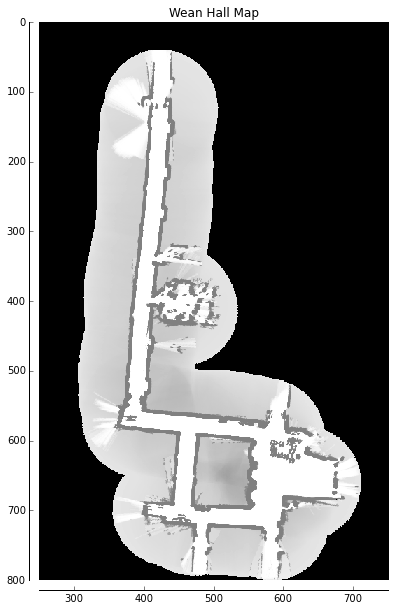

In [111]:
global_map = mcl.occupancy_map('data/map/wean.dat.gz')
mcl.draw_map_state(global_map)

# Unit Tests:

## sample_list_by_weight()

In [257]:
toy_list = [l for l in 'abcd']
weights  = [10,5,1,0.1]

sample_list = [mcl.sample_list_by_weight(toy_list, weights) 
               for _ in range(100)]
print(sample_list[:10])
df = pd.DataFrame(sample_list)
print("\nValue Counts in first location:")
print(df[0].value_counts())

[['d', 'a', 'b', 'c'], ['b', 'a', 'a', 'b'], ['a', 'b', 'b', 'a'], ['a', 'a', 'a', 'b'], ['b', 'b', 'a', 'a'], ['a', 'c', 'a', 'a'], ['a', 'a', 'a', 'a'], ['a', 'a', 'a', 'a'], ['b', 'b', 'b', 'b'], ['a', 'a', 'a', 'a']]

Value Counts in first location:
a    57
b    38
c     4
d     1
Name: 0, dtype: int64
